In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.preprocessing import StandardScaler

# Download NLTK resources if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mafuangimemkamon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mafuangimemkamon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mafuangimemkamon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [75]:
df = pd.read_csv('processed_data/computation_courses.csv').drop_duplicates('course name')
#df = df[df['filename'].str.contains('STAT')|df['text'].str.lower().str.contains('statistics')]
df = df[df['course name'].str.contains('STAT')]
df


,filename,course department,course name,Name,text,cleaned_text
7,STAT 123 - 2022 Spring (126048).pdf,STAT,STAT 123,STAT 123: Applied Quantitative Finance,"Thank\tyou\tfor\ttaking\tStat\t123\t2022,\tQua...","Thank you for taking Stat 123 2022, Quantitati..."
9,STAT 364 - 2022 Spring (214539).pdf,STAT,STAT 364,STAT 364: Scalable Statistical Inference for B...,Stat364 : Scalable Statistical Inference for B...,Stat364 : Scalable Statistical Inference for B...
13,STAT 216 - 2024 Fall (218350).pdf,STAT,STAT 216,STAT 216: Topics in High-Dimensional Probabili...,Course\tgoals:\nSuccessful\tstudents:\n1.\twil...,Course goals: Successful students: 1. will be ...
14,BIOSTAT 281_BST 281 - 2024 Spring (190119).pdf,BIOSTAT,BIOSTAT 281,BIOSTAT 281/BST 281: Genomic Data Manipulation,\n1 \n \nBST 281: Genomic Data Manipulation ...,1 BST 281: Genomic Data Manipulation (Spring ...
18,STAT 114 - 2024 Spring (224023).pdf,STAT,STAT 114,STAT 114: Introduction to Bioinformatics and S...,STAT 114: Introduction to Bioinformatics and S...,STAT 114: Introduction to Bioinformatics and S...
19,BIOSTAT 232_BST 232 - 2024 Fall (190049).pdf,BIOSTAT,BIOSTAT 232,BIOSTAT 232/BST 232: Methods,SYLLABUS FOR BIOSTAT/BST 232: METHODS Harvard ...,SYLLABUS FOR BIOSTAT/BST 232: METHODS Harvard ...
24,BIOSTAT 258_BST 258 - 2024 Spring (223906).pdf,BIOSTAT,BIOSTAT 258,BIOSTAT 258/BST 258: Causal Inference: Theory ...,Biostatistics 258 Spring 2024 Syllabus\nCausal...,Biostatistics 258 Spring 2024 Syllabus Causal ...
32,STAT 149 - 2024 Spring (118974).pdf,STAT,STAT 149,STAT 149: Generalized Linear Models,Course\tdescription\n:\t\t\nSequel\tto\tStatis...,"Course description : Sequel to Statistics 139,..."
35,BIOSTAT 230 - 2020 Fall (119844).pdf,BIOSTAT,BIOSTAT 230,BIOSTAT 230/BST 230: Probability I,1 Syllabus \n31 August 2020 \nBIO230- Biosta...,1 Syllabus 31 August 2020 BIO230- Biostat230 P...
38,STAT 185 - 2024 Fall (213478) (1).pdf,STAT,STAT 185,STAT 185: Introduction to Dimension Reduction,Statistics 185: Introduction to Unsupervised L...,Statistics 185: Introduction to Unsupervised L...


In [76]:
documents = df['cleaned_text'].values

In [105]:

ls = []
vectorizer = CountVectorizer(
    max_df=0.9,
    min_df=10,
    stop_words='english',
    token_pattern=r'(?u)\b[A-Za-z]+\b'  # Only keep words with alphabetic characters
)
doc_term_matrix = vectorizer.fit_transform(documents)
    
for num_topics in np.arange(2,10):
    N = 20
    # Vectorize text
    
    # Fit LDA
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(doc_term_matrix)
    
    topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
    
    top_words = np.argsort(topic_word_distributions, axis=1)[:, -N:]
    vocabulary = np.array(vectorizer.get_feature_names_out())
    topic_top_words = vocabulary[top_words]
    
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Example: Cosine similarity between word distributions
    def coherence_score(topic_words, doc_term_matrix):
        scores = []
        for words in topic_words:
            word_indices = [vectorizer.vocabulary_[w] for w in words if w in vectorizer.vocabulary_]
            sub_matrix = doc_term_matrix[:, word_indices].toarray()
            similarities = cosine_similarity(sub_matrix.T)
            upper_tri_indices = np.triu_indices_from(similarities, k=1)
            scores.append(similarities[upper_tri_indices].mean())
        return np.mean(scores)
    
    coherence = coherence_score(topic_top_words, doc_term_matrix)
    ls.append(coherence)
    print(num_topics, np.round(coherence,3), np.round(lda.perplexity(doc_term_matrix),1))


2 0.548 379.0
3 0.587 372.5
4 0.534 369.5
5 0.506 375.2
6 0.497 369.3
7 0.492 368.3
8 0.474 368.0
9 0.465 372.4


In [106]:
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(doc_term_matrix)

# Display the topics
feature_names = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}: ", [feature_names[i] for i in topic.argsort()[-10:]])

Topic 1:  ['journal', 's', 'et', 'al', 'learning', 'e', 'j', 'statistical', 'inference', 'data']
Topic 2:  ['teaching', 'problem', 'harvard', 'assignments', 'stat', 'final', 'r', 'statistics', 'students', 'class']
Topic 3:  ['final', 'work', 'methods', 's', 'data', 'class', 'harvard', 'homework', 'lecture', 'students']


In [107]:

# Step 3: Get topic distribution for each document
topic_distribution = lda.transform(doc_term_matrix)

# Step 4: Perform PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
topic_distribution_2d = pca.fit_transform(topic_distribution)

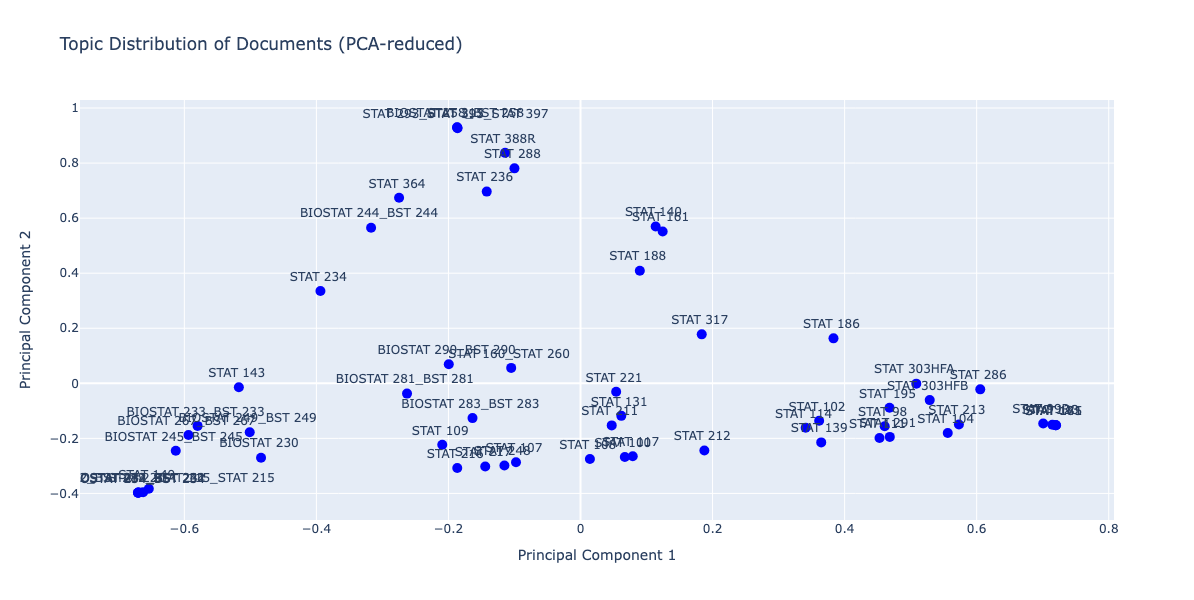

In [108]:
import plotly.graph_objects as go

# Step 5: Create interactive scatter plot using Plotly
fig = go.Figure()

# Add scatter plot
fig.add_trace(go.Scatter(
    x=topic_distribution_2d[:, 0], 
    y=topic_distribution_2d[:, 1],
    mode='markers+text',
    text=df['filename'].str.split('-').str[0],
    textposition='top center',
    marker=dict(size=10, color='blue')
))

# Title and labels
fig.update_layout(
    title="Topic Distribution of Documents (PCA-reduced)",
    xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2",
    template="plotly",
    showlegend=False,
    width=1000,  # Width of the plot (in pixels)
    height=600   # Height of the plot (in pixels)
)

# Show plot
fig.show()


In [57]:
# Preprocess the data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]  # Lemmatize and remove non-alphabetic tokens
    tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
    return ' '.join(tokens)  # Join tokens back into a single string

# Preprocess each document
processed_docs = [preprocess(doc) for doc in documents]

# Convert documents to a matrix of token counts
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_docs)

# Train the LDA model
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42, max_iter=100)
lda_model.fit(X)
print(lda_model.perplexity(X))

# Display the topics
feature_names = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda_model.components_):
    print(f"Topic {idx + 1}: ", [feature_names[i] for i in topic.argsort()[-10:]])

1754.4624531467302
Topic 1:  ['final', 'project', 'assignment', 'learning', 'research', 'problem', 'class', 'student', 'data', 'course']
Topic 2:  ['et', 'journal', 'statistical', 'february', 'pm', 'variable', 'pset', 'friday', 'inference', 'process']
Topic 3:  ['also', 'topic', 'science', 'section', 'center', 'statistic', 'class', 'student', 'teaching', 'course']
Topic 4:  ['assignment', 'method', 'model', 'data', 'exam', 'homework', 'class', 'lecture', 'student', 'course']
Topic 5:  ['laan', 'statistical', 'van', 'et', 'der', 'al', 'effect', 'inference', 'doi', 'causal']


In [58]:

# Step 3: Get topic distribution for each document
topic_distribution = lda_model.transform(X)

# Step 4: Perform PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
topic_distribution_2d = pca.fit_transform(topic_distribution)

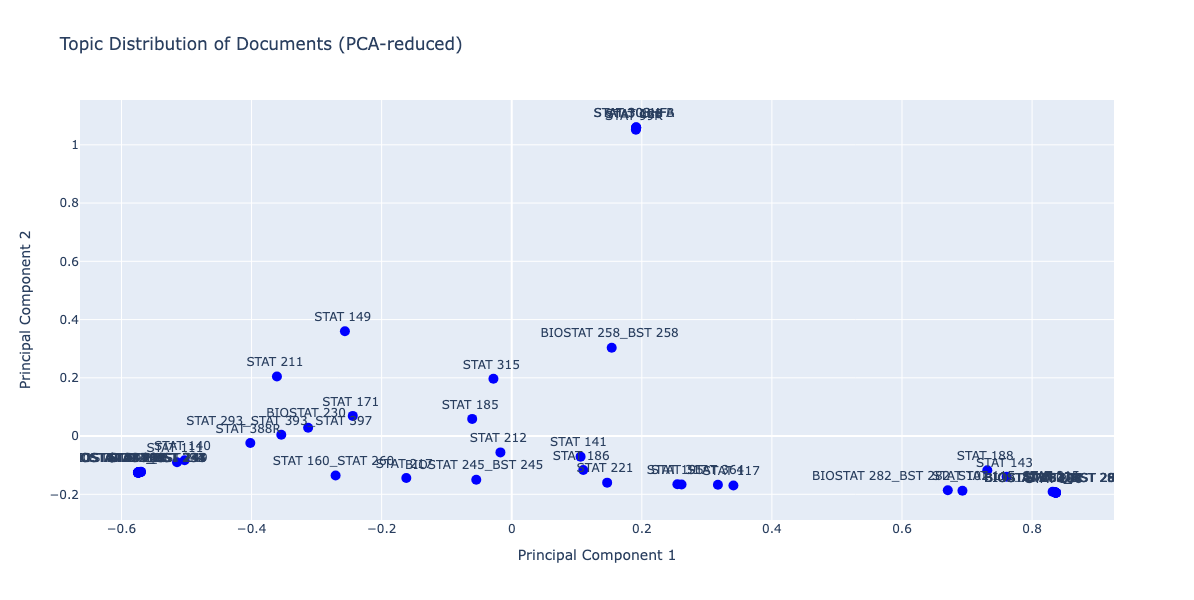

In [59]:
import plotly.graph_objects as go

# Step 5: Create interactive scatter plot using Plotly
fig = go.Figure()

# Add scatter plot
fig.add_trace(go.Scatter(
    x=topic_distribution_2d[:, 0], 
    y=topic_distribution_2d[:, 1],
    mode='markers+text',
    text=df['filename'].str.split('-').str[0],
    textposition='top center',
    marker=dict(size=10, color='blue')
))

# Title and labels
fig.update_layout(
    title="Topic Distribution of Documents (PCA-reduced)",
    xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2",
    template="plotly",
    showlegend=False,
    width=1000,  # Width of the plot (in pixels)
    height=600   # Height of the plot (in pixels)
)

# Show plot
fig.show()


In [111]:
df[df['filename'].str.contains('STAT 161')]['Name'].values

array(['STAT 161: Introduction to Nonparametric Methods'], dtype=object)